In [101]:
import numpy as np
import benchmark_functions as bf
import matplotlib.pyplot as plt

# Thiết lập danh sách các hàm làm chuẩn

In [102]:
dimensions = 20

functions_list = [
    bf.SphereFunction(dimensions),
    bf.EllipsoidFunction(dimensions),
    bf.SumOfDifferentPowersFunction(dimensions),
    bf.QuinticFunction(dimensions),
    bf.DropWaveFunction(dimensions),
    bf.WeierstrassFunction(dimensions),
    bf.Alpine1Function(dimensions),
    bf.AckleysFunction(dimensions),
    bf.GriewanksFunction(dimensions),
    bf.RastriginsFunction(dimensions),
    bf.HappyCatFunction(dimensions),
    bf.HGBatFunction(dimensions),
    bf.RosenbrocksFunction(dimensions),
    bf.HighConditionedEllipticFunction(dimensions),
    bf.DiscusFunction(dimensions),
    bf.BentCigarFunction(dimensions),
    bf.PermDBetaFunction(dimensions),
    bf.SchaffersF7Function(dimensions),
    bf.ExpandedSchaffersF6Function(dimensions),
    bf.RotatedHyperEllipsoidFunction(dimensions),
]

In [237]:
# Thuật toán Tiến hóa vi phân
class DifferentialEvolution:
    def __init__(self, objective_function, dimensions, bounds, population_size, mutation_factor, crossover_probability, generations):
        self.objective_function = objective_function
        self.dimensions = dimensions
        self.bounds = bounds
        self.population_size = population_size
        self.mutation_factor = mutation_factor
        self.crossover_probability = crossover_probability
        self.generations = generations
        self.best_solution = None
        self.best_value = float('inf')
        self.history = []  # Lưu giá trị tốt nhất của mỗi thế hệ
        self.population = None

    # Khởi tạo quần thể
    def initialize_population(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimensions))

    # Hàm đột biến
    def mutate(self, population, idx):
        indices = [i for i in range(self.population_size) if i != idx]
        a, b, c = np.random.choice(indices, 3, replace=False)
        mutant_vector = np.clip(population[a] + self.mutation_factor * (population[b] - population[c]), self.bounds[0], self.bounds[1])
        return mutant_vector

    # Hàm lai ghép
    def crossover(self, target_vector, mutant_vector):
        crossover_mask = np.random.rand(self.dimensions) < self.crossover_probability
        trial_vector = np.where(crossover_mask, mutant_vector, target_vector)
        return trial_vector
    
    # Hàm chọn lọc
    def select(self, population, trial_vector, idx):
        if self.objective_function.evaluate(trial_vector) < self.objective_function.evaluate(population[idx]):
            population[idx] = trial_vector
            value = self.objective_function.evaluate(population[idx])
            if value < self.best_value:
                self.best_value = value
                self.best_solution = population[idx]

    # Hàm thực thi
    def run(self):
        self.population = self.initialize_population()
        
        for generation in range(self.generations):
            for idx in range(self.population_size):
                mutant_vector = self.mutate(self.population, idx)
                trial_vector = self.crossover(self.population[idx], mutant_vector)
                self.select(self.population, trial_vector, idx)
            self.history.append(self.best_value)
            
        return self.best_solution, self.best_value

In [25]:
# Tạo một thực thể của giải thuật DE với các tham số cụ thể
de = DifferentialEvolution(
    objective_function=functions_list[12],  # Chọn một hàm từ danh sách hàm đã tạo trước đó
    dimensions=dimensions,
    bounds=(-5, 10),  # Giới hạn của không gian tìm kiếm
    population_size=40,  # Kích thước quần thể
    mutation_factor=0.8,  # Hệ số đột biến
    crossover_probability=0.9,  # Xác suất lai ghép
    generations=5000  # Số thế hệ
)

# Chạy giải thuật
best_solution, best_value = de.run()

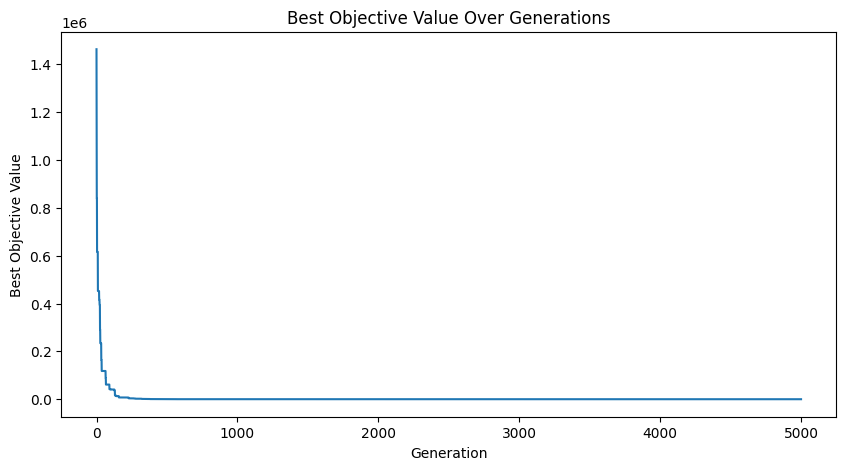

In [28]:
# Vẽ đồ thị
plt.figure(figsize=(10, 5))
plt.plot(de.history)
plt.title('Best Objective Value Over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Objective Value')
plt.show()

In [27]:
best_value

1.3060340319624217e-05

# Thuật toán di truyền với phép lai ghép SBX

In [29]:
# Thuật toán di truyền (với phép lai ghép SBX)
class GeneticAlgorithm:
    def __init__(self, objective_function, dimensions, bounds, population_size, crossover_probability, mutation_probability, generations):
        self.objective_function = objective_function
        self.dimensions = dimensions
        self.bounds = bounds
        self.population_size = population_size
        self.crossover_probability = crossover_probability
        self.mutation_probability = mutation_probability
        self.generations = generations
        self.best_solution = None
        self.best_value = float('inf')
        self.history = []

    def initialize_population(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimensions))

    def sbx_crossover(self, parent1, parent2, eta=30):
        child1, child2 = np.copy(parent1), np.copy(parent2)
        for i in range(self.dimensions):
            if np.random.rand() <= self.crossover_probability:
                if abs(parent1[i] - parent2[i]) > 1e-14:
                    x1 = min(parent1[i], parent2[i])
                    x2 = max(parent1[i], parent2[i])
                    rand = np.random.rand()
                    beta = 1.0 + (2.0 * (x1 - self.bounds[0]) / (x2 - x1))
                    alpha = 2.0 - beta**-(eta + 1)
                    if rand <= 1.0 / alpha:
                        beta_q = (rand * alpha)**(1.0 / (eta + 1))
                    else:
                        beta_q = (1.0 / (2.0 - rand * alpha))**(1.0 / (eta + 1))
                    child1[i] = 0.5 * ((x1 + x2) - beta_q * (x2 - x1))

                    beta = 1.0 + (2.0 * (self.bounds[1] - x2) / (x2 - x1))
                    alpha = 2.0 - beta**-(eta + 1)
                    if rand <= 1.0 / alpha:
                        beta_q = (rand * alpha)**(1.0 / (eta + 1))
                    else:
                        beta_q = (1.0 / (2.0 - rand * alpha))**(1.0 / (eta + 1))
                    child2[i] = 0.5 * ((x1 + x2) + beta_q * (x2 - x1))
        return child1, child2

    def mutate(self, individual):
        for i in range(self.dimensions):
            if np.random.rand() < self.mutation_probability:
                individual[i] += np.random.normal(0, 1)
                individual[i] = np.clip(individual[i], self.bounds[0], self.bounds[1])
        return individual

    def select(self, population):
        indices = np.random.randint(0, self.population_size, (self.population_size, 2))
        selected = np.array([population[i] if self.objective_function.evaluate(population[i]) < self.objective_function.evaluate(population[j]) else population[j] for i, j in indices])
        return selected

    def run(self):
        population = self.initialize_population()
        for generation in range(self.generations):
            new_population = []
            
            for i in range(0, self.population_size, 2):
                parent1, parent2 = population[np.random.choice(self.population_size)], population[np.random.choice(self.population_size)]
                child1, child2 = self.sbx_crossover(parent1, parent2)
                new_population.extend([self.mutate(child1), self.mutate(child2)])
                
            population = self.select(new_population)
            best_in_population = min(population, key=lambda x: self.objective_function.evaluate(x))
            best_value_in_population = self.objective_function.evaluate(best_in_population)
            
            if best_value_in_population < self.best_value:
                self.best_solution = best_in_population
                self.best_value = best_value_in_population
            self.history.append(self.best_value)
        return self.best_solution, self.best_value

In [40]:
ga = GeneticAlgorithm(
    objective_function=functions_list[12],  # Chọn một hàm từ danh sách đã tạo
    dimensions=dimensions,
    bounds=(-10, 10),
    population_size=40,
    crossover_probability=0.9,
    mutation_probability=0.1,
    generations=5000
)

best_solution, best_value = ga.run()

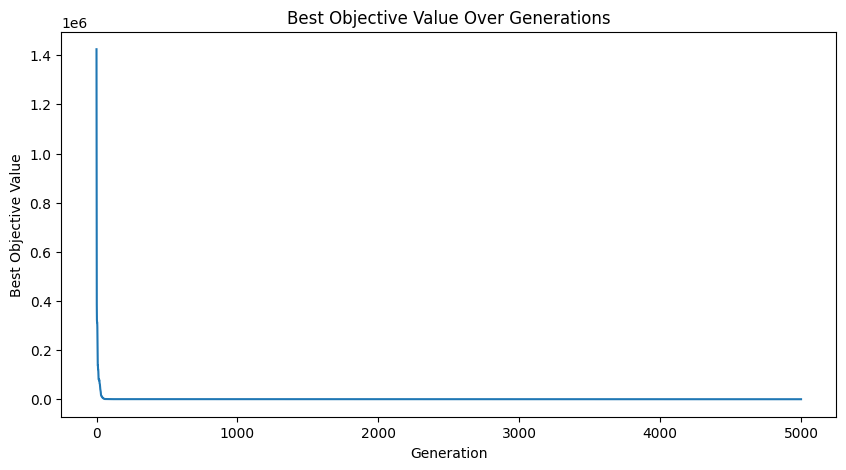

In [41]:
# Vẽ đồ thị
plt.figure(figsize=(10, 5))
plt.plot(ga.history)
plt.title('Best Objective Value Over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Objective Value')
plt.show()

In [42]:
best_value

87.90729351092718

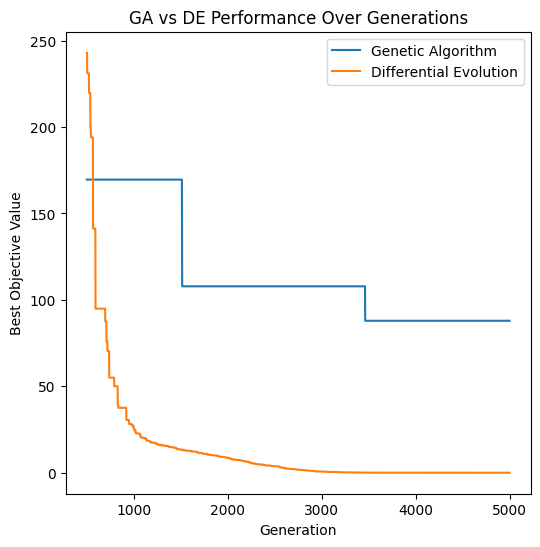

In [43]:
# Lựa chọn phạm vi thế hệ từ 500 đến 5000
generations = range(500, 5000)
ga_values = ga.history[500:5000]
de_values = de.history[500:5000]

# Vẽ đồ thị
plt.figure(figsize=(6, 6))
plt.plot(generations, ga_values, label='Genetic Algorithm')
plt.plot(generations, de_values, label='Differential Evolution')
plt.title('GA vs DE Performance Over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Objective Value')
plt.legend()
plt.show()

# Giải thuật MFEA

In [139]:
class MFEA:
    def __init__(self, tasks, num_individuals, num_dimensions, bounds, num_generations, rmp, mutation_index):
        self.tasks = tasks  
        self.num_individuals = num_individuals
        self.num_dimensions = num_dimensions
        self.bounds = bounds
        self.num_generations = num_generations
        self.rmp = rmp  
        self.mutation_index = mutation_index
        self.population = None
        self.factorial_cost = None
        self.factorial_rank = None
        self.scalar_fitness = None
        self.skill_factor = None
        self.offspring_population = None
        self.offspring_skill_factor = None
        self.offspring_factorial_cost = None
        self.history = np.full((num_generations, len(tasks)), np.inf)

    def initialize(self):
        self.population = np.random.uniform(self.bounds[0], self.bounds[1], (self.num_individuals, self.num_dimensions))
        self.factorial_cost = np.full((self.num_individuals, len(self.tasks)), np.inf)
        self.factorial_rank = np.zeros_like(self.factorial_cost)
        self.scalar_fitness = np.zeros(self.num_individuals)

    def evaluate(self):
        for i, individual in enumerate(self.population):
            for task_idx, task in enumerate(self.tasks):
                self.factorial_cost[i, task_idx] = task.evaluate(individual)
        self.factorial_rank = np.argsort(np.argsort(self.factorial_cost, axis=0), axis=0) + 1
        self.scalar_fitness = 1.0 / np.min(self.factorial_rank, axis=1)
        # Cập nhật skill factor dựa vào factorial rank thấp nhất cho mỗi cá thể
        self.skill_factor = np.argmin(self.factorial_rank, axis=1)

    def evaluate_offspring(self, offspring_population, offspring_skill_factor):
        offspring_factorial_cost = np.full((len(offspring_population), len(self.tasks)), np.inf)

        for i, individual in enumerate(offspring_population):
            task_idx = offspring_skill_factor[i]
            offspring_factorial_cost[i, task_idx] = self.tasks[task_idx].evaluate(individual)
            # Gán factorial cost là vô cùng cho những tác vụ không được đánh giá
            unassessed_tasks = [j for j in range(len(self.tasks)) if j != task_idx]
            for unassessed_task_idx in unassessed_tasks:
                offspring_factorial_cost[i, unassessed_task_idx] = np.inf

        self.offspring_population = offspring_population
        self.offspring_skill_factor = offspring_skill_factor
        self.offspring_factorial_cost = offspring_factorial_cost

    def assortative_mating(self):
        offspring_population = []
        offspring_skill_factor = []
        while len(offspring_population) < self.num_individuals:
            p1, p2 = np.random.choice(self.num_individuals, 2, replace=False)
            if (self.skill_factor[p1] == self.skill_factor[p2]) or (np.random.rand() < self.rmp):
                c1, c2 = self.crossover(self.population[p1], self.population[p2])
                sf = self.skill_factor[p1] if np.random.rand() < 0.5 else self.skill_factor[p2]
                offspring_population.extend([c1, c2])
                offspring_skill_factor.extend([sf, sf])
            else:
                c1 = self.mutate(self.population[p1])
                c2 = self.mutate(self.population[p2])
                offspring_population.extend([c1, c2])
                offspring_skill_factor.extend([self.skill_factor[p1], self.skill_factor[p2]])
        return np.array(offspring_population), np.array(offspring_skill_factor)

    def crossover(self, parent1, parent2, eta=30):
        child1, child2 = np.copy(parent1), np.copy(parent2)
        for i in range(self.num_dimensions):
            if abs(parent1[i] - parent2[i]) > 1e-14:
                x1 = min(parent1[i], parent2[i])
                x2 = max(parent1[i], parent2[i])
                rand = np.random.rand()
                beta = 1.0 + (2.0 * (x1 - self.bounds[0]) / (x2 - x1))
                alpha = 2.0 - beta**-(eta + 1)
                if rand <= 1.0 / alpha:
                    beta_q = (rand * alpha)**(1.0 / (eta + 1))
                else:
                    beta_q = (1.0 / (2.0 - rand * alpha))**(1.0 / (eta + 1))
                child1[i] = 0.5 * ((x1 + x2) - beta_q * (x2 - x1))
                beta = 1.0 + (2.0 * (self.bounds[1] - x2) / (x2 - x1))
                alpha = 2.0 - beta**-(eta + 1)
                if rand <= 1.0 / alpha:
                    beta_q = (rand * alpha)**(1.0 / (eta + 1))
                else:
                    beta_q = (1.0 / (2.0 - rand * alpha))**(1.0 / (eta + 1))
                child2[i] = 0.5 * ((x1 + x2) + beta_q * (x2 - x1))
        return child1, child2

    def mutate(self, individual):
        for i in range(self.num_dimensions):
            delta = np.random.rand()
            if delta < 0.5:
                multiplier = (2 * delta)**(1 / (self.mutation_index + 1)) - 1
            else:
                multiplier = 1 - (2 * (1 - delta))**(1 / (self.mutation_index + 1))
            individual[i] += multiplier * (self.bounds[1] - self.bounds[0])
            individual[i] = np.clip(individual[i], self.bounds[0], self.bounds[1])
        return individual

    def selection(self, offspring_population, offspring_skill_factor, offspring_factorial_cost):
        # Gộp quần thể hiện tại và quần thể con
        combined_population = np.vstack((self.population, offspring_population))
        combined_skill_factor = np.concatenate((self.skill_factor, offspring_skill_factor))
        combined_factorial_cost = np.vstack((self.factorial_cost, offspring_factorial_cost))

        # Tính lại scalar_fitness cho quần thể gộp
        combined_factorial_rank = np.argsort(np.argsort(combined_factorial_cost, axis=0), axis=0) + 1
        combined_scalar_fitness = 1.0 / np.min(combined_factorial_rank, axis=1)

        # Chọn ra những cá thể tốt nhất
        best_indices = np.argsort(combined_scalar_fitness)[::-1][:self.num_individuals]
        self.population = combined_population[best_indices]
        self.skill_factor = combined_skill_factor[best_indices]
        self.factorial_cost = combined_factorial_cost[best_indices]
        self.scalar_fitness = combined_scalar_fitness[best_indices]

    def run(self):
        self.initialize()
        self.evaluate()
        best_task_fitness = np.min(self.factorial_cost, axis=0)

        for generation in range(self.num_generations):
            offspring_population, offspring_skill_factor = self.assortative_mating()
            self.evaluate_offspring(offspring_population, offspring_skill_factor)
            self.selection(offspring_population, offspring_skill_factor, self.offspring_factorial_cost)
        
            # Cập nhật lịch sử và giá trị fitness tốt nhất cho mỗi tác vụ
            for task_idx in range(len(self.tasks)):
                task_individuals = np.where(self.skill_factor == task_idx)[0]
                if task_individuals.size > 0:
                    best_fitness = np.min(self.factorial_cost[task_individuals, task_idx])
                    if best_fitness < best_task_fitness[task_idx]:
                        best_task_fitness[task_idx] = best_fitness
                # Cập nhật history
                self.history[generation, task_idx] = best_task_fitness[task_idx]

        return self.history, best_task_fitness

In [177]:
# 16 hàm chuẩn đồng dạng, nghiệm tối ưu toàn cục (0,0,...,0)
functions_list = [
    bf.SphereFunction(dimensions),
    bf.EllipsoidFunction(dimensions),
    bf.SumOfDifferentPowersFunction(dimensions),
    bf.DropWaveFunction(dimensions),
    bf.WeierstrassFunction(dimensions),
    bf.Alpine1Function(dimensions),
    bf.AckleysFunction(dimensions),
    bf.GriewanksFunction(dimensions),
    bf.RastriginsFunction(dimensions),
    bf.RosenbrocksFunction(dimensions),
    bf.HighConditionedEllipticFunction(dimensions),
    bf.DiscusFunction(dimensions),
    bf.BentCigarFunction(dimensions),
    bf.SchaffersF7Function(dimensions),
    bf.ExpandedSchaffersF6Function(dimensions),
    bf.RotatedHyperEllipsoidFunction(dimensions),
]

In [192]:
mfea = MFEA(
    tasks=functions_list,
    num_individuals=40,
    num_dimensions=dimensions,
    bounds=(-20,20),
    num_generations=5000,
    rmp=0.5,
    mutation_index=30,
)

history, best_task_fitness = mfea.run()

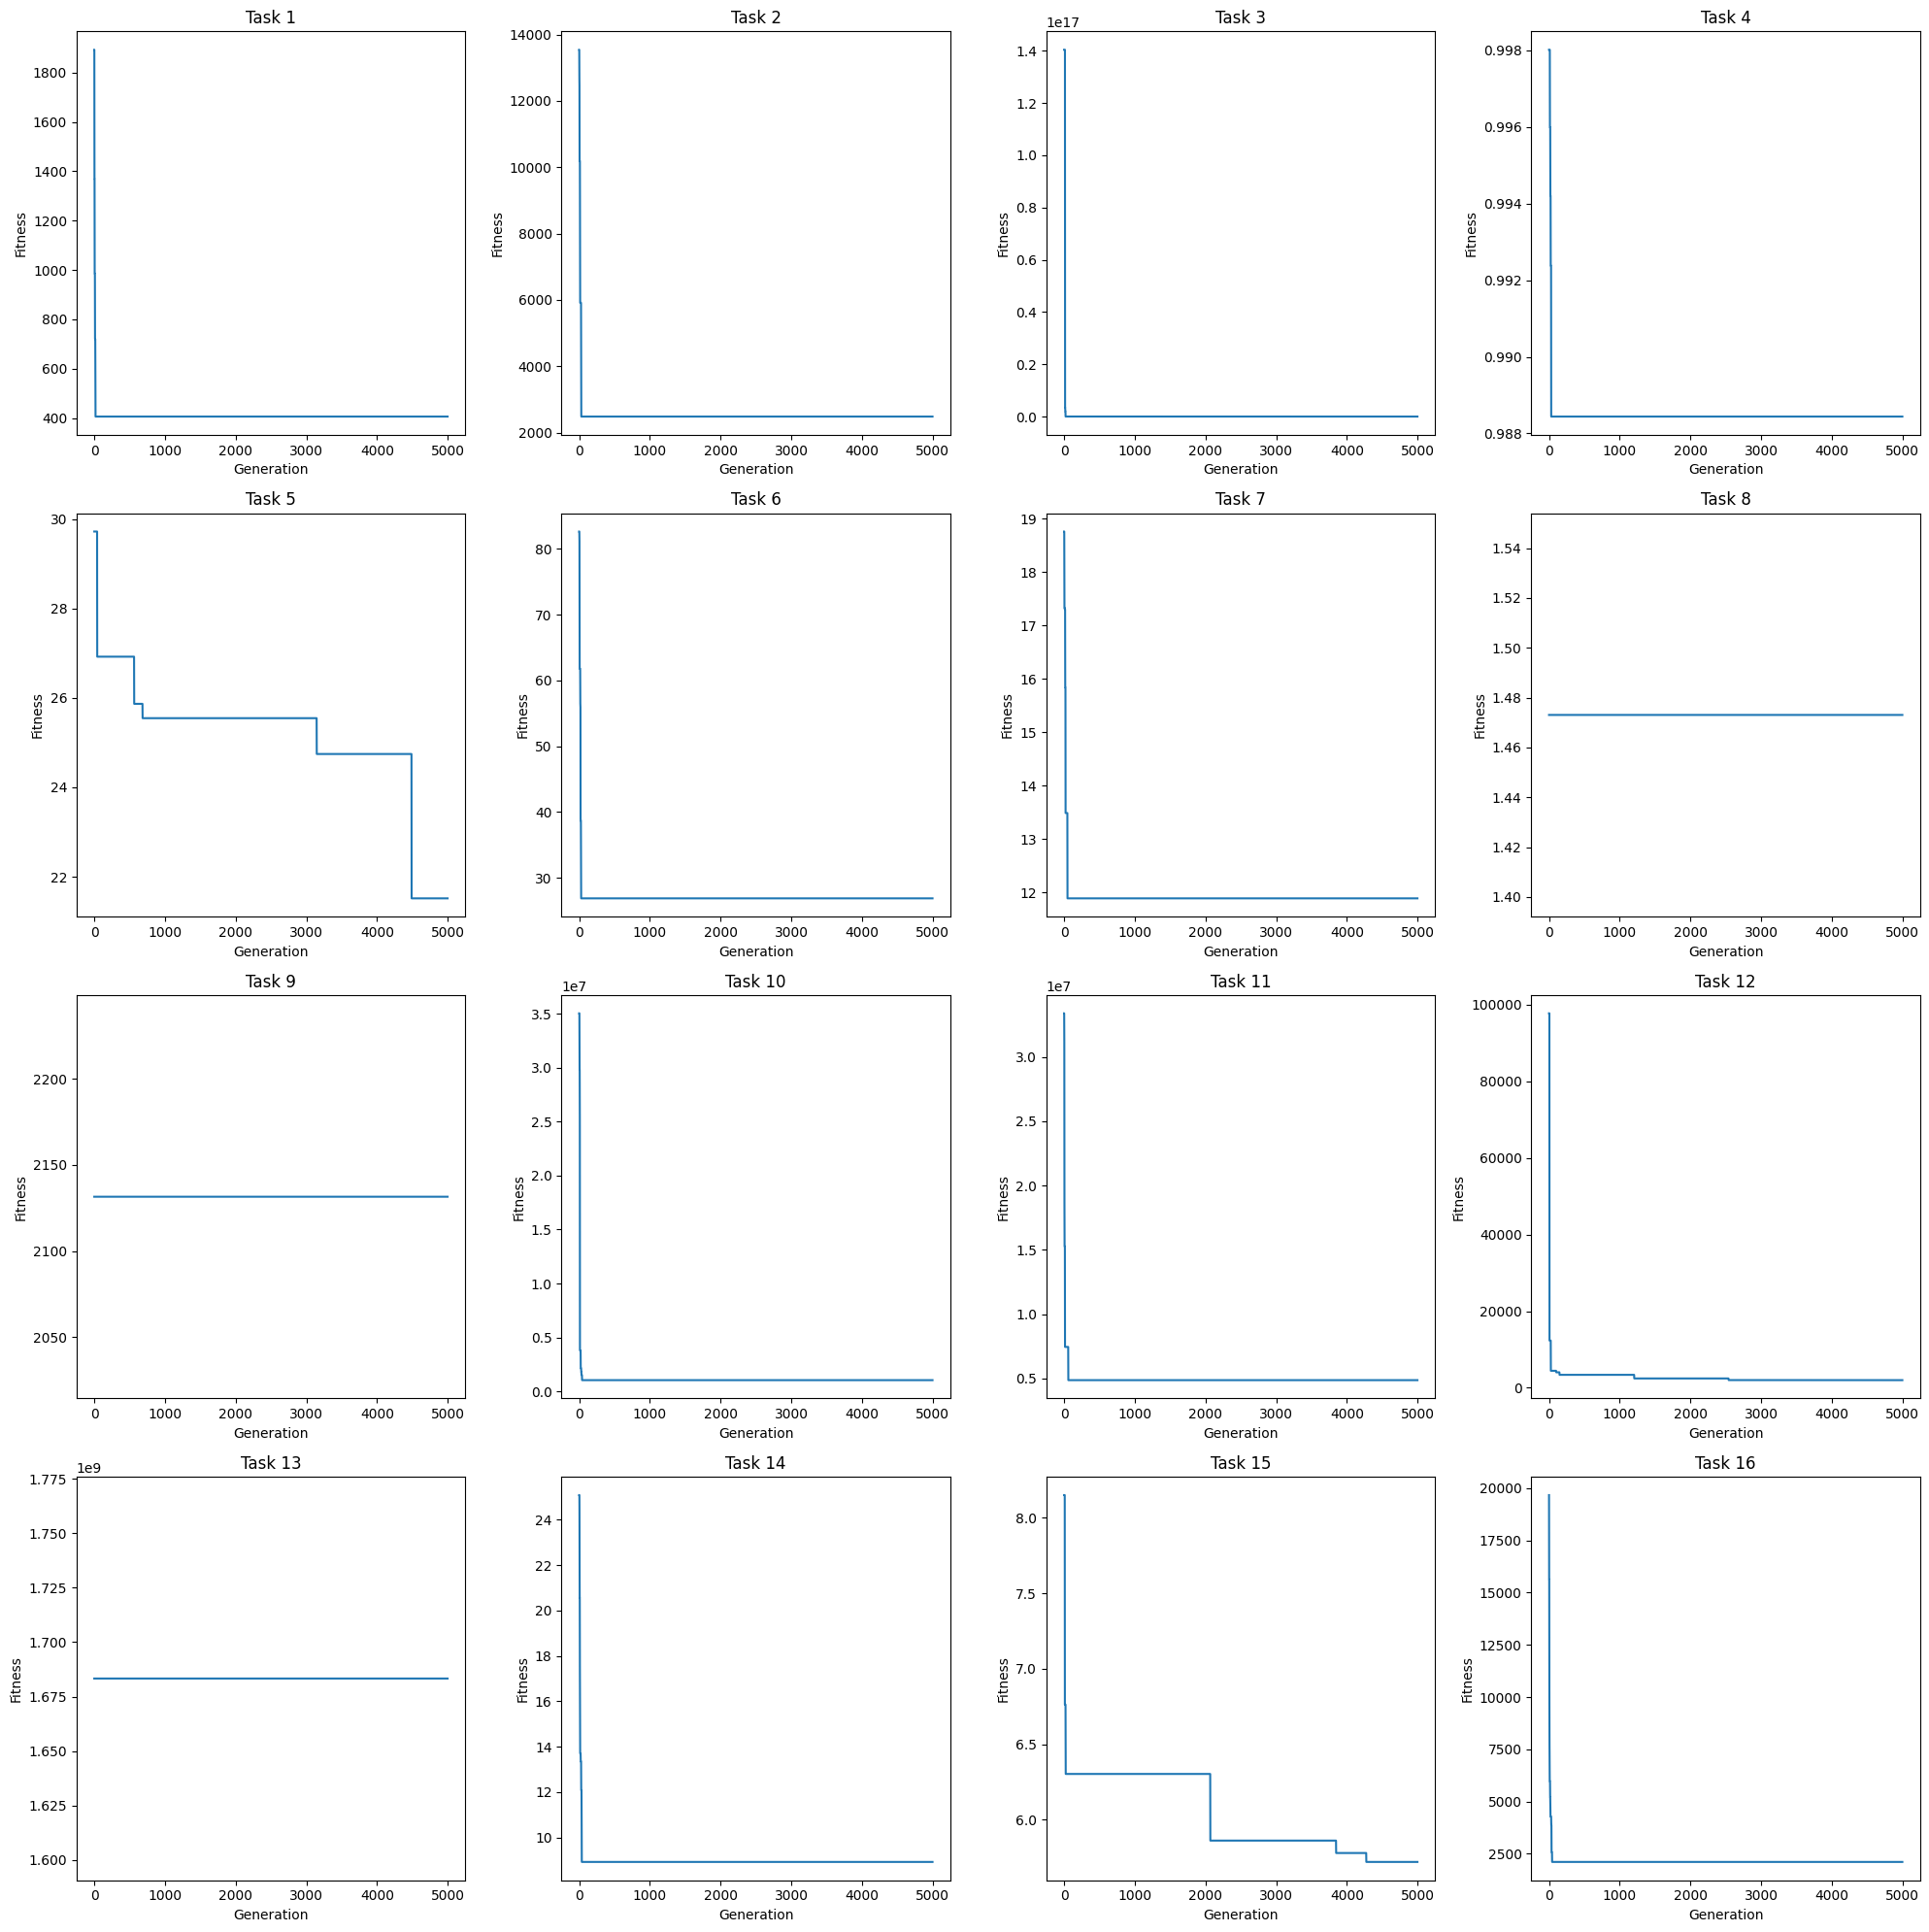

In [193]:
# Tạo figure và các subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))  # 5 hàng và 4 cột

# Duyệt qua mỗi task và tạo subplot tương ứng
for i in range(16):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    ax.plot(history[:, i])
    ax.set_title(f'Task {i+1}')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')

plt.tight_layout()
plt.show()

In [194]:
print(best_task_fitness)

[4.05804496e+02 2.48327098e+03 7.68451801e+10 9.88440632e-01
 2.15155752e+01 2.68521088e+01 1.18870454e+01 1.47305918e+00
 2.13154558e+03 1.04834270e+06 4.88073115e+06 1.99998064e+03
 1.68332956e+09 8.92550737e+00 5.72060076e+00 2.10919543e+03]


# Sử dụng 2 trình DE riêng biệt giải quyết 2 hàm

In [205]:
tasks = [
    bf.Alpine1Function(dimensions),
    bf.RosenbrocksFunction(dimensions),
]

In [206]:
de_task0 = DifferentialEvolution(
    objective_function=tasks[0],  # Chọn một hàm từ danh sách hàm đã tạo trước đó
    dimensions=dimensions,
    bounds=(-10, 10),  # Giới hạn của không gian tìm kiếm
    population_size=40,  # Kích thước quần thể
    mutation_factor=0.8,  # Hệ số đột biến
    crossover_probability=0.9,  # Xác suất lai ghép
    generations=5000  # Số thế hệ
)

# Chạy giải thuật
best_solution_task0, best_value_task0 = de_task0.run()

best_value_task0

0.00030191767244237345

In [207]:
de_task1 = DifferentialEvolution(
    objective_function=tasks[1],  # Chọn một hàm từ danh sách hàm đã tạo trước đó
    dimensions=dimensions,
    bounds=(-10,10),  # Giới hạn của không gian tìm kiếm
    population_size=40,  # Kích thước quần thể
    mutation_factor=0.8,  # Hệ số đột biến
    crossover_probability=0.9,  # Xác suất lai ghép
    generations=5000  # Số thế hệ
)

# Chạy giải thuật
best_solution_task1, best_value_task1 = de_task1.run()

best_value_task1

8.377198471369997e-05

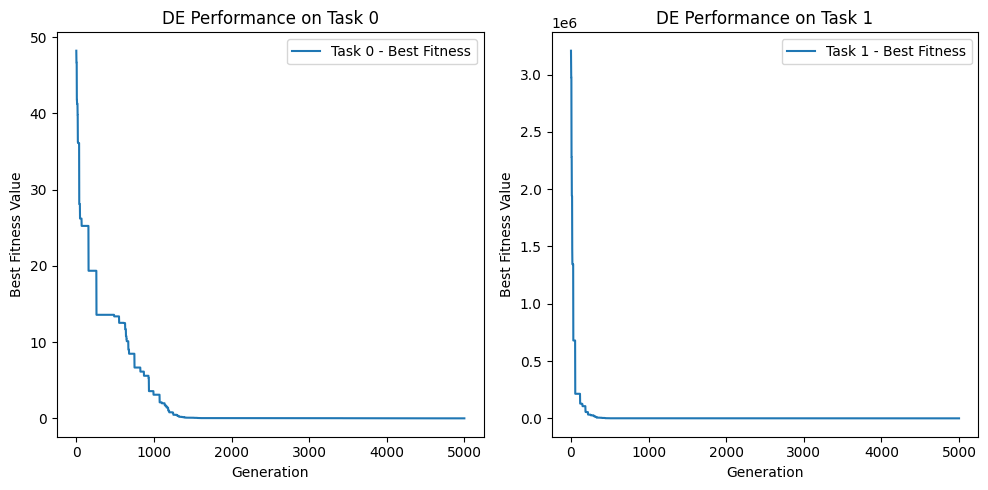

In [208]:
# Giả định là đã có lịch sử từ việc chạy DE trên cả hai tasks
history_task0 = de_task0.history
history_task1 = de_task1.history

# Tạo figure và subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Vẽ đồ thị cho task 0
axs[0].plot(history_task0, label='Task 0 - Best Fitness')
axs[0].set_title('DE Performance on Task 0')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Best Fitness Value')
axs[0].legend()

# Vẽ đồ thị cho task 1
axs[1].plot(history_task1, label='Task 1 - Best Fitness')
axs[1].set_title('DE Performance on Task 1')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Best Fitness Value')
axs[1].legend()

# Hiển thị đồ thị
plt.tight_layout()
plt.show()

# Sử dụng MFEA giải đồng thời 2 bài toán

In [215]:
mfea = MFEA(
    tasks=tasks, 
    num_individuals=80, 
    num_dimensions=dimensions,
    bounds=(-10,10), 
    num_generations=5000, 
    rmp=0.5,
    mutation_index=20,
)

history, best_task_fitness = mfea.run()

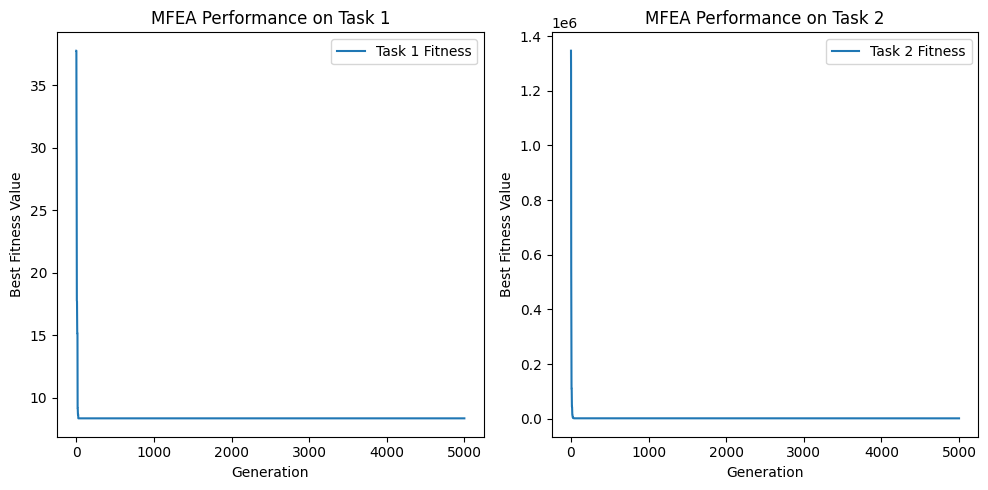

In [216]:
# Tạo figure và các subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Vẽ đồ thị cho task 1
axs[0].plot(history[:, 0], label='Task 1 Fitness')
axs[0].set_title('MFEA Performance on Task 1')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Best Fitness Value')
axs[0].legend()

# Vẽ đồ thị cho task 2
axs[1].plot(history[:, 1], label='Task 2 Fitness')
axs[1].set_title('MFEA Performance on Task 2')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Best Fitness Value')
axs[1].legend()

# Hiển thị đồ thị
plt.tight_layout()
plt.show()

In [217]:
print(best_task_fitness)

[   8.36297412 1316.27010274]


Tóm lại giải thuật MFEA cho kết quả yếu hơn.

# Thiết lập thuật toán MFEA với DAE mã hóa tường minh
* Bộ Denoising Autoencoder nhận đầu vào là tập $N$ lời giải của task 0, làm hỏng (thêm nhiễu Gaussian) với đầu ra mong muốn là tập $N$ lời giải của task 1. Mục tiêu cực tiểu hàm mất mát là trung bình sai số bình phương. 
* Sau đó bộ DAE được huấn luyện sẽ biến đổi $N$ lời giải tốt nhất của task 0 thành $N$ lời giải để tiêm vào quần thể của task 1.
* Mỗi task được giải bằng trình tiến hóa độc lập bằng thuật toán DE và chuyển giao kiến thức thông qua bộ DAE diễn ra mỗi 10 thế hệ.

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim

In [249]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, dimensions):
        super(DenoisingAutoencoder, self).__init__()
        # Định nghĩa lớp mã hóa và giải mã
        
        # Lớp mã hóa
        self.encoder = nn.Sequential(
            nn.Linear(dimensions, 16), # Giảm chiều
            nn.ReLU(True),
            nn.Linear(16, 8),
            nn.ReLU(True)
        )
        
        # Lớp giải mã
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(True),
            nn.Linear(16, dimensions),
            nn.ReLU()
        )

    def forward(self, x):
        # Thêm nhiễu Gaussian
        x_noisy = x + torch.randn_like(x) * 0.1
        x_noisy = torch.clamp(x_noisy, -10, 10)  # Đảm bảo rằng dữ liệu vẫn nằm trong khoảng hợp lệ
        encoded = self.encoder(x_noisy)
        decoded = self.decoder(encoded)
        return decoded

In [223]:
# Lưu trọng số của mô hình
torch.save(model.state_dict(), 'your_model_weights.pth')

# Load lại trọng số của mô hình từ tệp đã lưu
loaded_model = DenoisingAutoencoder(dimensions)
loaded_model.load_state_dict(torch.load('your_model_weights.pth'))
loaded_model.eval()  # Chuyển sang chế độ đánh giá

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=16, out_features=20, bias=True)
    (4): ReLU()
  )
)

In [226]:
# Chuẩn bị dữ liệu mới cần tái tạo
new_data = torch.randn(1, dimensions)  # Đầu vào mới cần tái tạo

# Tái tạo dữ liệu mới bằng cách truyền qua mô hình
reconstructed_data = loaded_model(new_data)

print(reconstructed_data)

tensor([[0.0921, 0.6707, 0.0000, 0.2894, 0.0000, 0.0420, 0.5359, 0.2799, 0.5803,
         0.2823, 0.0622, 0.2895, 0.0000, 0.0000, 0.2499, 0.6757, 0.0000, 0.2879,
         0.0000, 0.0984]], grad_fn=<ReluBackward0>)


In [252]:
class ImplicitGeneticTransfer:
    def __init__(self, objective_function1, objective_function2, dimensions, bounds=(-10, 10), population_size=100, mutation_factor=0.8, crossover_probability=0.7, generations=1000):
        self.de1 = DifferentialEvolution(
            objective_function1, 
            dimensions, 
            bounds, 
            population_size, 
            mutation_factor, 
            crossover_probability, 
            generations
        )
        self.de2 = DifferentialEvolution(
            objective_function2, 
            dimensions, 
            bounds, 
            population_size, 
            mutation_factor, 
            crossover_probability, 
            generations
        )
        self.dae = DenoisingAutoencoder(dimensions)
        self.optimizer = optim.Adam(self.dae.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()
        self.history1 = []
        self.history2 = []

    def train_dae(self, data_in, data_out, epochs=5000):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            reconstructions = self.dae(data_in)
            loss = self.criterion(reconstructions, data_out)
            loss.backward()
            self.optimizer.step()

    def transfer_solutions(self, population1, population2):
        # Lấy 10 lời giải tốt nhất từ quần thể 1
        transfer_indices = np.argsort(self.de1.objective_function.evaluate(x) for x in population1)[:10]
        transferred_solutions = population1[transfer_indices]
        
        # Chuyển đổi thành tensor PyTorch
        transferred_solutions_tensor = torch.tensor(transferred_solutions, dtype=torch.float32)

        # Bổ sung vào quần thể 2 thông qua mô hình DAE
        population2[:10, :] = self.dae(transferred_solutions_tensor).detach().numpy()
        
        # Sắp xếp lại quần thể 2 và giữ lại số lượng cá thể là population_size
        fitness_values = np.array([self.de2.objective_function.evaluate(x) for x in population2])
        sorted_indices = np.argsort(fitness_values)
        population2[:population_size, :] = population2[sorted_indices[:population_size]]

    def evolve(self):
        # Chạy DE cho từng hàm
        self.de1.run()
        self.de2.run()

        # Lấy mẫu và huấn luyện DAE sau khi chạy DE 1000 thế hệ
        sample_size = 50
        selected_indices1 = np.random.choice(len(self.de1.population), sample_size, replace=False)
        selected_indices2 = np.random.choice(len(self.de2.population), sample_size, replace=False)
        data_in1 = torch.tensor(self.de1.population[selected_indices1], dtype=torch.float32)
        data_out2 = torch.tensor(self.de2.population[selected_indices2], dtype=torch.float32)

        # Huấn luyện DAE
        self.train_dae(data_in1, data_out2)

        # Tiếp tục chạy DE và thực hiện MFEA step
        for generation in range(2000):
            if generation % 100 == 0 and generation > 0:
                self.transfer_solutions(self.de1.population, self.de2.population)
                
            for idx in range(self.de1.population_size):
                # Chạy DE cho bài toán 1
                mutant_vector1 = self.de1.mutate(self.de1.population, idx)
                trial_vector1 = self.de1.crossover(self.de1.population[idx], mutant_vector1)
                self.de1.select(self.de1.population, trial_vector1, idx)
                
                # Chạy DE cho bài toán 2
                mutant_vector2 = self.de2.mutate(self.de2.population, idx)
                trial_vector2 = self.de2.crossover(self.de2.population[idx], mutant_vector2)
                self.de2.select(self.de2.population, trial_vector2, idx)
                
            self.history1.append(self.de1.best_value)
            self.history2.append(self.de2.best_value)
            
        return self.history1, self.history2

In [253]:
# Thực hiện
dimensions = 20
objective_function1 = bf.Alpine1Function(dimensions)
objective_function2 = bf.RosenbrocksFunction(dimensions) 
bounds = (-10, 10)
population_size = 100
mutation_factor = 0.8
crossover_probability = 0.7
generations = 1000

igt_algorithm = ImplicitGeneticTransfer(
    objective_function1, 
    objective_function2, 
    dimensions, 
    bounds, 
    population_size, 
    mutation_factor, 
    crossover_probability, 
    generations
)

igt_algorithm.evolve()
best_solution1, best_value1 = igt_algorithm.de1.best_solution, igt_algorithm.de1.best_value
best_solution2, best_value2 = igt_algorithm.de2.best_solution, igt_algorithm.de2.best_value

In [254]:
best_value1

5.418062083519885

In [255]:
best_value2

13.55882589015178

Kết quả tốt hơn rõ ràng hihi.